In [1]:
!pip install -q ultralytics imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00


In [2]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [3]:
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [4]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

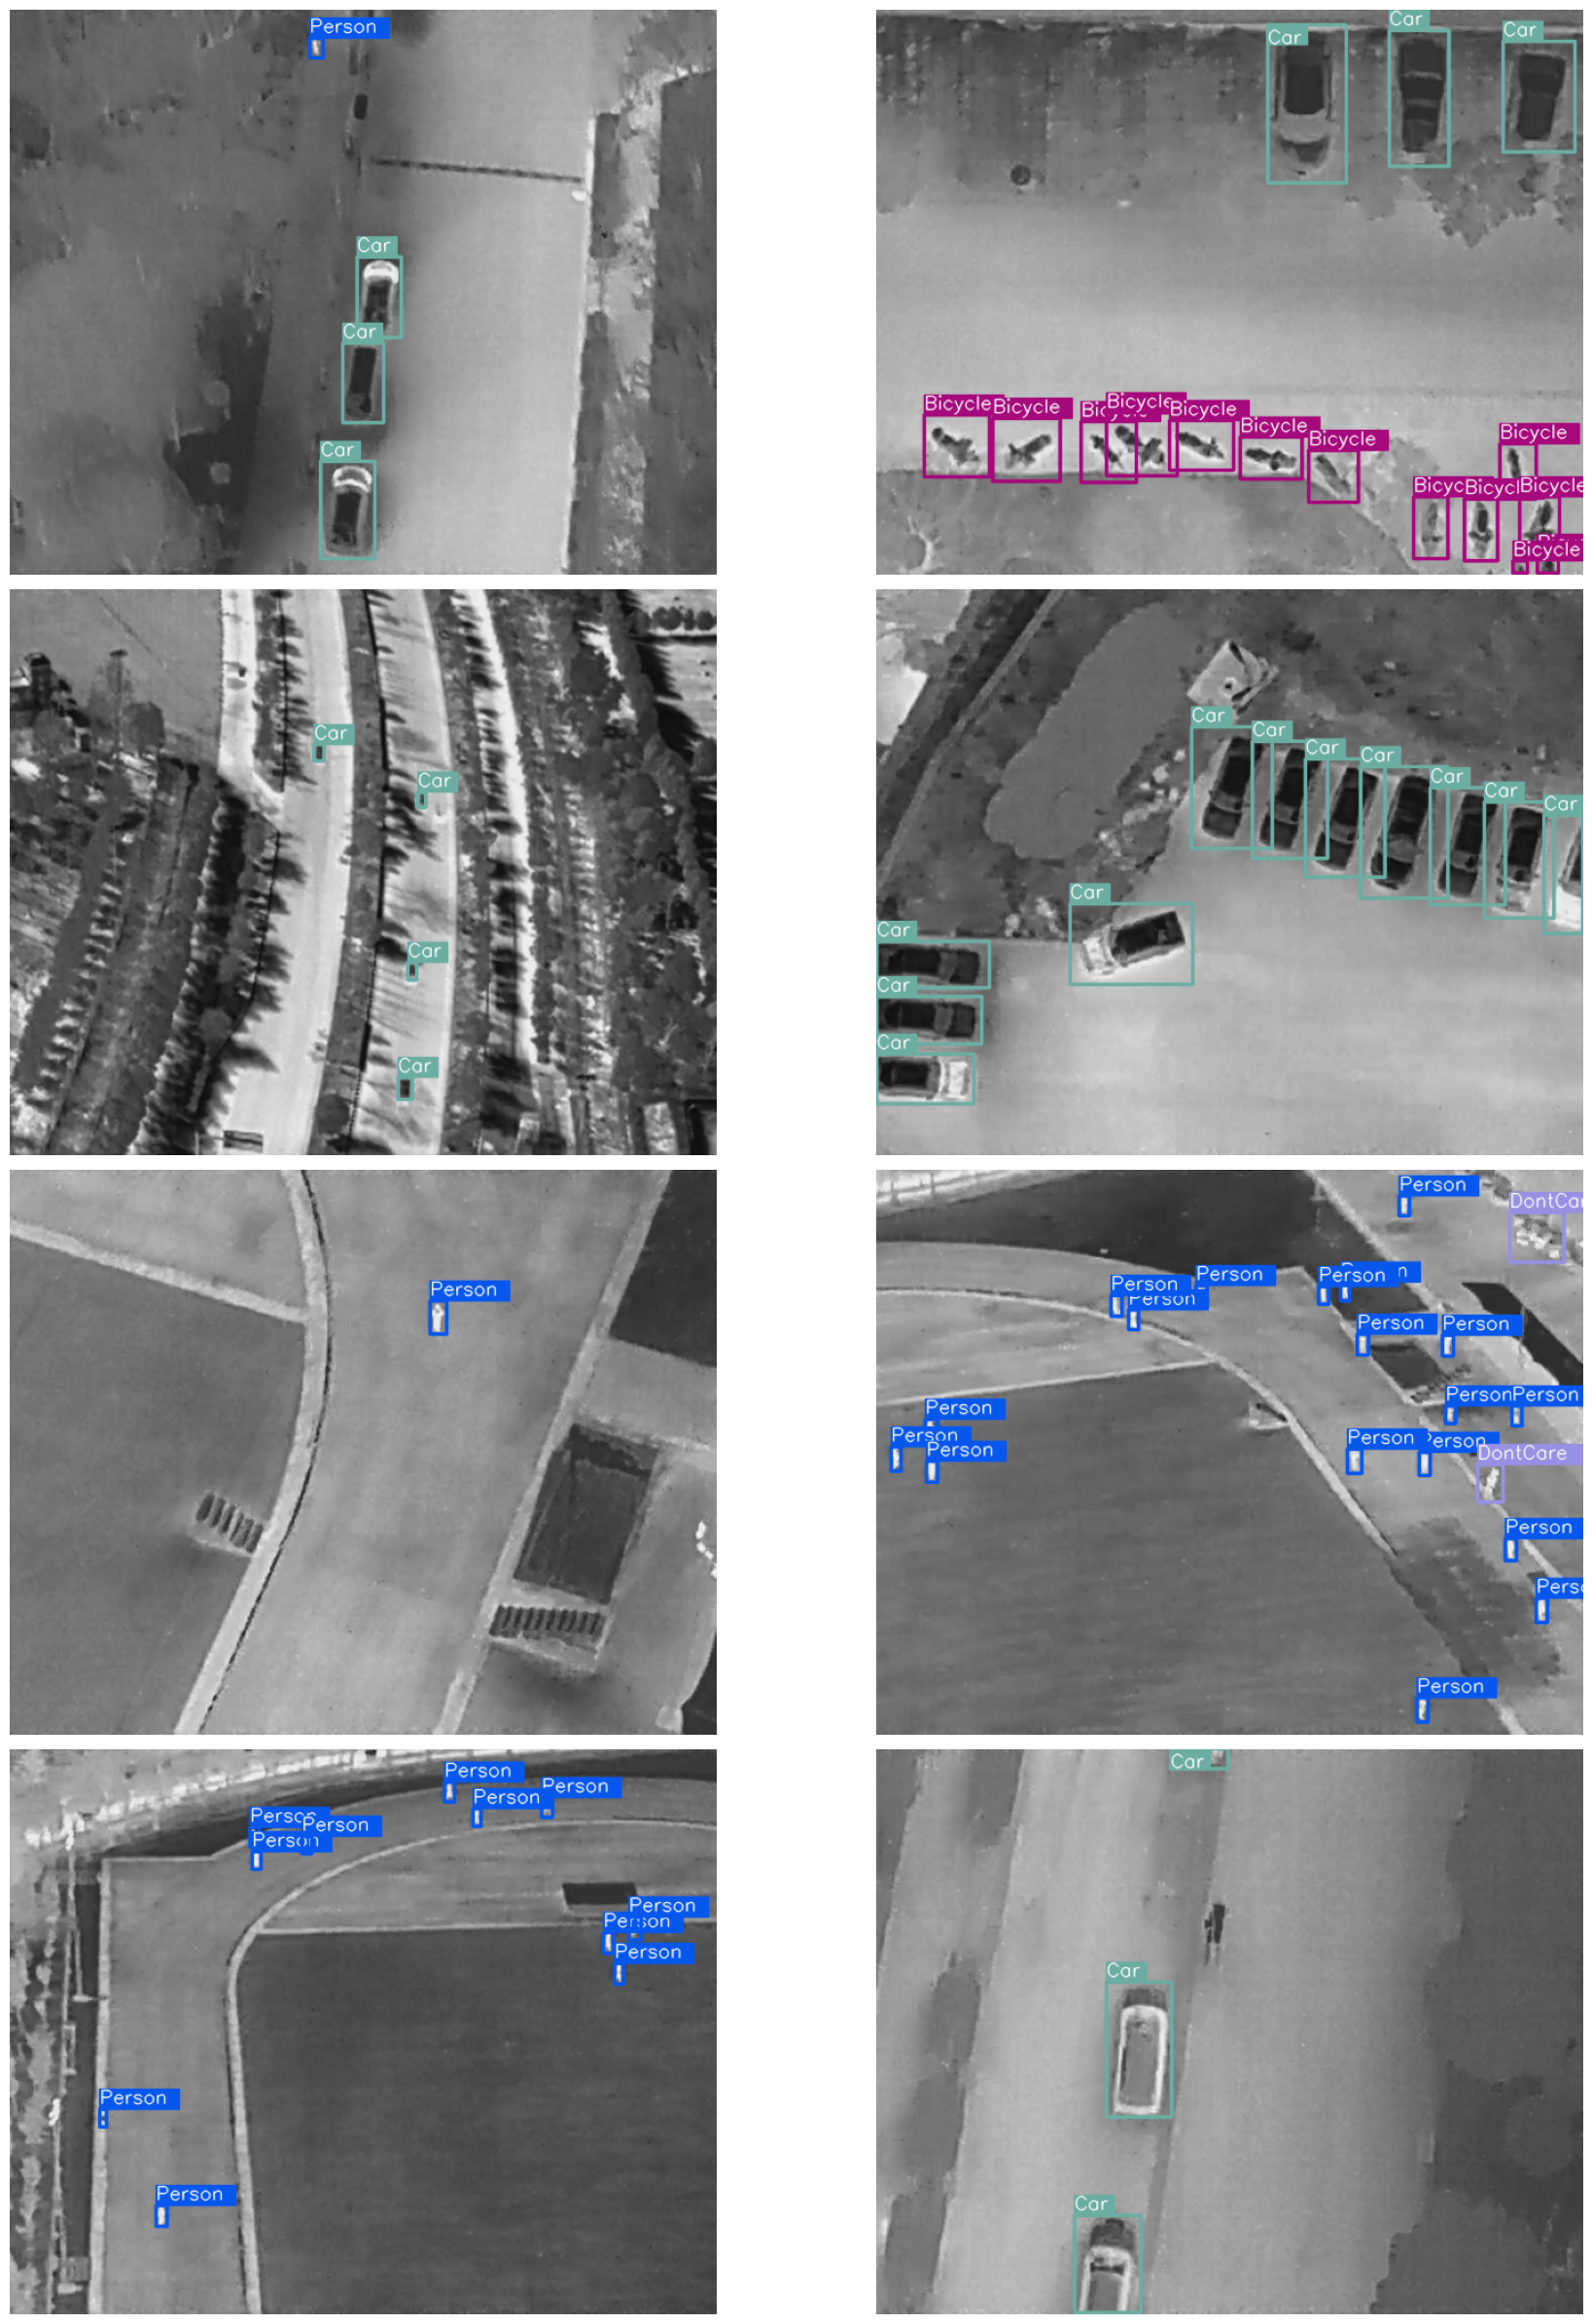

In [7]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [8]:
import yaml

# data.yaml oluşturma
data_dict = {
    "train": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/train",
    "val": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/val",
    "test": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test",
    "nc": 5,
    "names": ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
}

with open("dataset.yaml", "w") as f:
    yaml.dump(data_dict, f, sort_keys=False)


# model_dict = {
#     "nc": 5,

#     # Layer 0: Load EfficientNet-B0 via Torchvision
#     "backbone": [
#         [-1, 1, "TorchVision", [1280, "efficientnet_b0", "DEFAULT", True, 2, True]], # backbone index 0
#         [-1, 1, "nn.Identity", []], # index 1
#         [-1, 1, "nn.Identity", []], # index 2

#         # ------ P3 Branch (target: 256 channels at 80 x 80)
#         # Extract EfficientNet output at index 3: shape [1, 40, 80, 80]
#         [0, 1, "Index", [40, 4]], # extracts raw feature from efficientnet layer 3 -> backbone index 3
#         [-1, 1, "Conv", [256, 1, 1]], # project from 40 to 256 channels
#         [-1, 1, "nn.Identity", []], # pin this as backbone index 4 (p3)

#         # --------- P4 Branch(target: 512 channels at 40 x 40)
#         # Extract EfficientNet output at index 5: shape [1, 112, 40, 40]
#         [0, 1, "Index", [112, 6]], # extracts raw feature from efficientnet layer 5 -> backbone index 5
#         [-1, 1, "Conv", [512, 1, 1]],
#         [-1, 1, "nn.Identity", []],# pin this as backbone index 6 (P4)

#         # ------------------------- P5 Branch (target: 1024 channels at 20 x 20)
#         [0, 1, "Index", [1280, 9]], # extracts raw feature from efficientnet layer 8 -> backbone index 7
#         [-1, 1, "Conv", [1024, 1, 1]], # project from 1280 to 1024 channels -> backbone index 8
#         [-1, 1, "SPPF", [1024, 5]] # SPPF block finalizes p5 -> backbone index 9
        
#     ],
#     "head": [
#         [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
#         [[-1, 6], 1, "Concat", [1]], # Concatenate upsampled P5 (backbone index 9) with P4 (backbone index 6)
#         [-1, 3, "C2f", [512, True]], # index 12

#         [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
#         [[-1, 4], 1, "Concat", [1]],
#         [-1, 3, "C2f", [256, True]],

#         [-1, 1, "Conv", [256, 3, 2]],
#         [[-1, 12], 1, "Concat", [1]],
#         [-1, 3, "C2f", [512, True]],

#         [-1, 1, "Conv", [512, 3, 2]],
#         [[-1, 9], 1, "Concat", [1]],
#         [-1, 3, "C2f", [1024, True]],

#         [[17, 20, 23], 1, "Detect", ["nc"]]
#     ]
# }

# with open("yolov8-custom.yaml", "w") as f:
#     yaml.dump(model_dict, f, sort_keys=False)
   

In [9]:
import yaml

all_models = {
    "efficientnet_b0_yolov8": {
        "nc": 5,
        "backbone": [
            [-1, 1, "TorchVision", [1280, "efficientnet_b0", "DEFAULT", True, 2, True]],
            [-1, 1, "nn.Identity", []],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [40, 4]],   # P3
            [-1, 1, "Conv", [256, 1, 1]],
            [-1, 1, "nn.Identity", []],  # pin P3 index
            [0, 1, "Index", [112, 6]],  # P4
            [-1, 1, "Conv", [512, 1, 1]],
            [-1, 1, "nn.Identity", []],  # pin P4 index
            [0, 1, "Index", [1280, 9]], # P5
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]  # pin P5 index
        ],
        "head": [
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 6], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2f", [256, True]],
            [-1, 1, "Conv", [256, 3, 2]],
            [[-1, 12], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "Conv", [512, 3, 2]],
            [[-1, 9], 1, "Concat", [1]],
            [-1, 3, "C2f", [1024, True]],
            [[17, 20, 23], 1, "Detect", ["nc"]]
        ]
    },

    "efficientnet_b0_yolov10": {
        "nc": 5,
        "backbone": [  
            [-1, 1, "TorchVision", [1280, "efficientnet_b0", "DEFAULT", True, 2, True]],
            [-1, 1, "nn.Identity", []],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [40, 4]],  
            [-1, 1, "Conv", [256, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [112, 6]], 
            [-1, 1, "Conv", [512, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [1280, 9]],
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]
        ],
        "head": [
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 6], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [512, True]],
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [256, True]],
            [-1, 1, "DynamicHead", [1024]],
            [[17, 20, 23], 1, "Detect", ["nc"]]
        ]
    },

    "efficientnet_b3_yolov8": {
        "nc": 5,
        "backbone": [
            [-1, 1, "TorchVision", [1536, "efficientnet_b3", "DEFAULT", True, 2, True]],
            [-1, 1, "nn.Identity", []],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [48, 4]],  
            [-1, 1, "Conv", [256, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [136, 6]], 
            [-1, 1, "Conv", [512, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [1536, 9]],
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]
        ],
        "head": [
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 6], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2f", [256, True]],
            [-1, 1, "Conv", [256, 3, 2]],
            [[-1, 12], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "Conv", [512, 3, 2]],
            [[-1, 9], 1, "Concat", [1]],
            [-1, 3, "C2f", [1024, True]],
            [[17, 20, 23], 1, "Detect", ["nc"]]
        ]
    },

    "efficientnet_b3_yolov10": {
        "nc": 5,
        "backbone": [
            [-1, 1, "TorchVision", [1536, "efficientnet_b3", "DEFAULT", True, 2, True]],
            [-1, 1, "nn.Identity", []],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [48, 4]],  
            [-1, 1, "Conv", [256, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [136, 6]], 
            [-1, 1, "Conv", [512, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [1536, 9]],
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]
        ],
        "head": [
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 6], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [512, True]],
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [256, True]],
            [-1, 1, "DynamicHead", [1024]],
            [[17, 20, 23], 1, "Detect", ["nc"]]
        ]
    }
}

with open("models.yaml", "w") as f:
    yaml.dump(all_models, f, sort_keys=False)


In [10]:
import yaml
from ultralytics import YOLO

with open('/kaggle/working/models.yaml') as f:
    models = yaml.safe_load(f)

model = all_models["efficientnet_b0_yolov8"]

with open('/kaggle/working/model.yaml', 'w') as f:
    yaml.dump(model, f)

yolo_efficientnet_model = YOLO('/kaggle/working/model.yaml')



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 176MB/s]


In [11]:
yolo_efficientnet_train = yolo_efficientnet_model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch = 16)

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/model.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        287       2460      0.914      0.765      0.811      0.521
                Person        171       1168      0.912      0.852       0.91      0.494
                   Car        136        719      0.958      0.972      0.988      0.757
               Bicycle         53        554      0.891      0.843      0.922      0.532
          OtherVehicle          9         12          1       0.73        0.8      0.647
              DontCare          5          7      0.809      0.429      0.437      0.175
Speed: 0.2ms preprocess, 12.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


In [12]:
!ls -l /kaggle/working/runs/detect/

total 4
drwxr-xr-x 3 root root 4096 Nov 17 19:17 train


In [13]:
best_efficientnet_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [14]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/train4"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

In [15]:
!zip -r /kaggle/working/runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/train_batch1.jpg (deflated 4%)
  adding: runs/detect/train/train_batch5040.jpg (deflated 11%)
  adding: runs/detect/train/confusion_matrix_normalized.png (deflated 21%)
  adding: runs/detect/train/BoxPR_curve.png (deflated 11%)
  adding: runs/detect/train/weights/ (stored 0%)
  adding: runs/detect/train/weights/best.pt (deflated 9%)
  adding: runs/detect/train/weights/last.pt (deflated 9%)
  adding: runs/detect/train/train_batch2.jpg (deflated 2%)
  adding: runs/detect/train/val_batch0_labels.jpg (deflated 7%)
  adding: runs/detect/train/labels.jpg (deflated 27%)
  adding: runs/detect/train/train_batch0.jpg (deflated 4%)
  adding: runs/detect/train/BoxF1_curve.png (deflated 7%)
  adding: runs/detect/train/results.csv (deflated 61%)
  adding: runs/detect/train/val_batch2_pred.jpg (deflated 6%)
  adding: runs/detect/train/val_batch2_labels.jpg (deflated 7%)


In [16]:
!ls -lh /kaggle/working/


total 182M
-rw-r--r-- 1 root root  325 Nov 17 17:44 dataset.yaml
-rw-r--r-- 1 root root 5.3K Nov 17 17:44 models.yaml
-rw-r--r-- 1 root root 1.2K Nov 17 17:44 model.yaml
---------- 1 root root 4.8M Nov 17 19:17 __notebook__.ipynb
drwxr-xr-x 3 root root 4.0K Nov 17 17:44 runs
-rw-r--r-- 1 root root 172M Nov 17 19:17 runs.zip
-rw-r--r-- 1 root root 5.4M Nov 17 17:45 yolo11n.pt


# Inference on Test Images


In [17]:
results = best_efficientnet_model(os.path.join(ROOT_DIR, test_imgs_dir), conf=0.5, agnostic_nms=True, iou=0.5, save=True)


image 1/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_03307.jpg: 512x640 1 Person, 10 Cars, 60.0ms
image 2/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08074.jpg: 512x640 7 Cars, 2 OtherVehicles, 21.1ms
image 3/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08091.jpg: 512x640 11 Cars, 21.4ms
image 4/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08100.jpg: 512x640 3 Cars, 21.3ms
image 5/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03327.jpg: 512x640 3 Persons, 21.0ms
image 6/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03332.jpg: 512x640 3 Persons, 21.6ms
image 7/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03342.jpg: 512x640 4 Persons, 21

In [18]:
import random
import matplotlib.pyplot as plt

def show_random_result(results):
    random_result = random.choice(results)   
    img = random_result.plot()               

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()




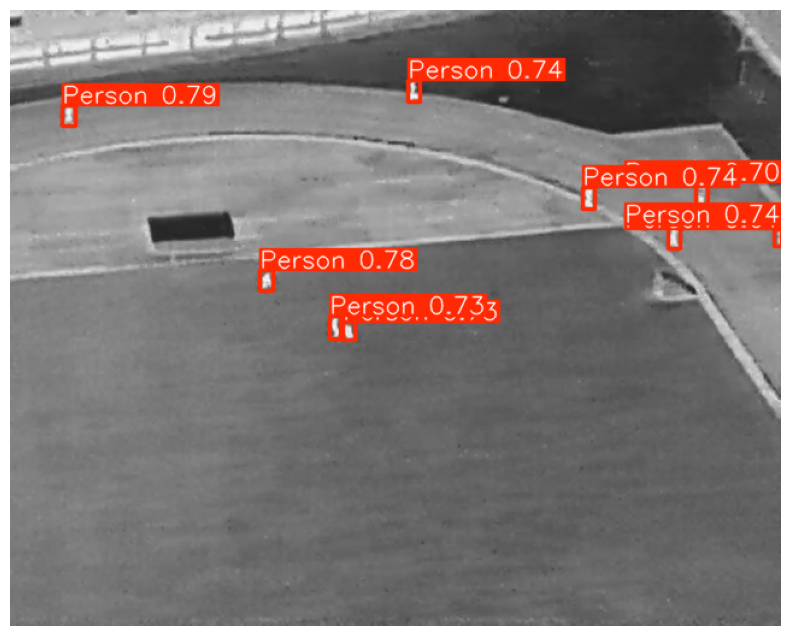

In [19]:
show_random_result(results)

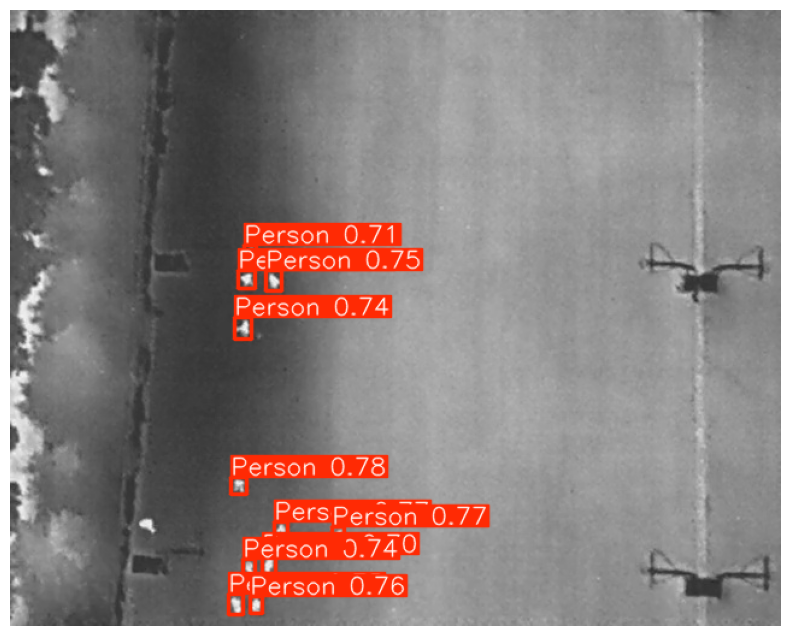

In [20]:
show_random_result(results)

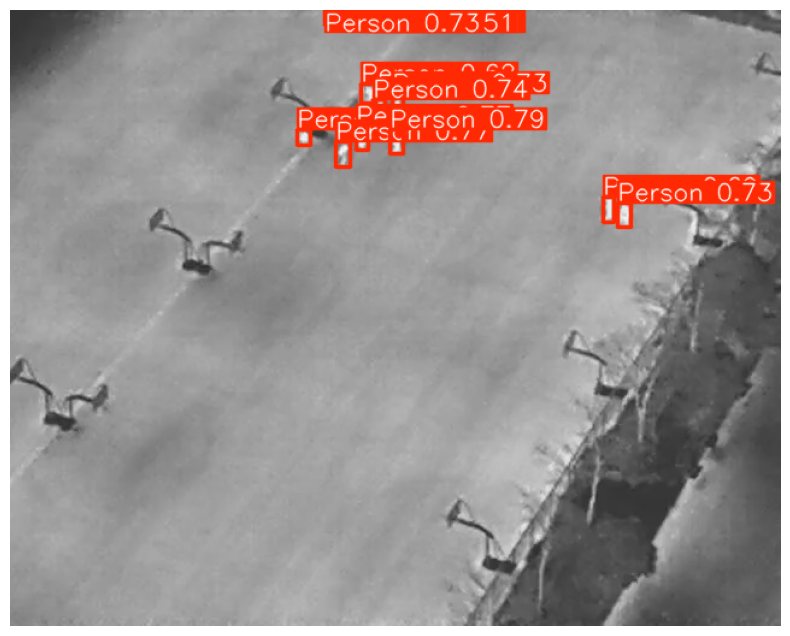

In [21]:

show_random_result(results)

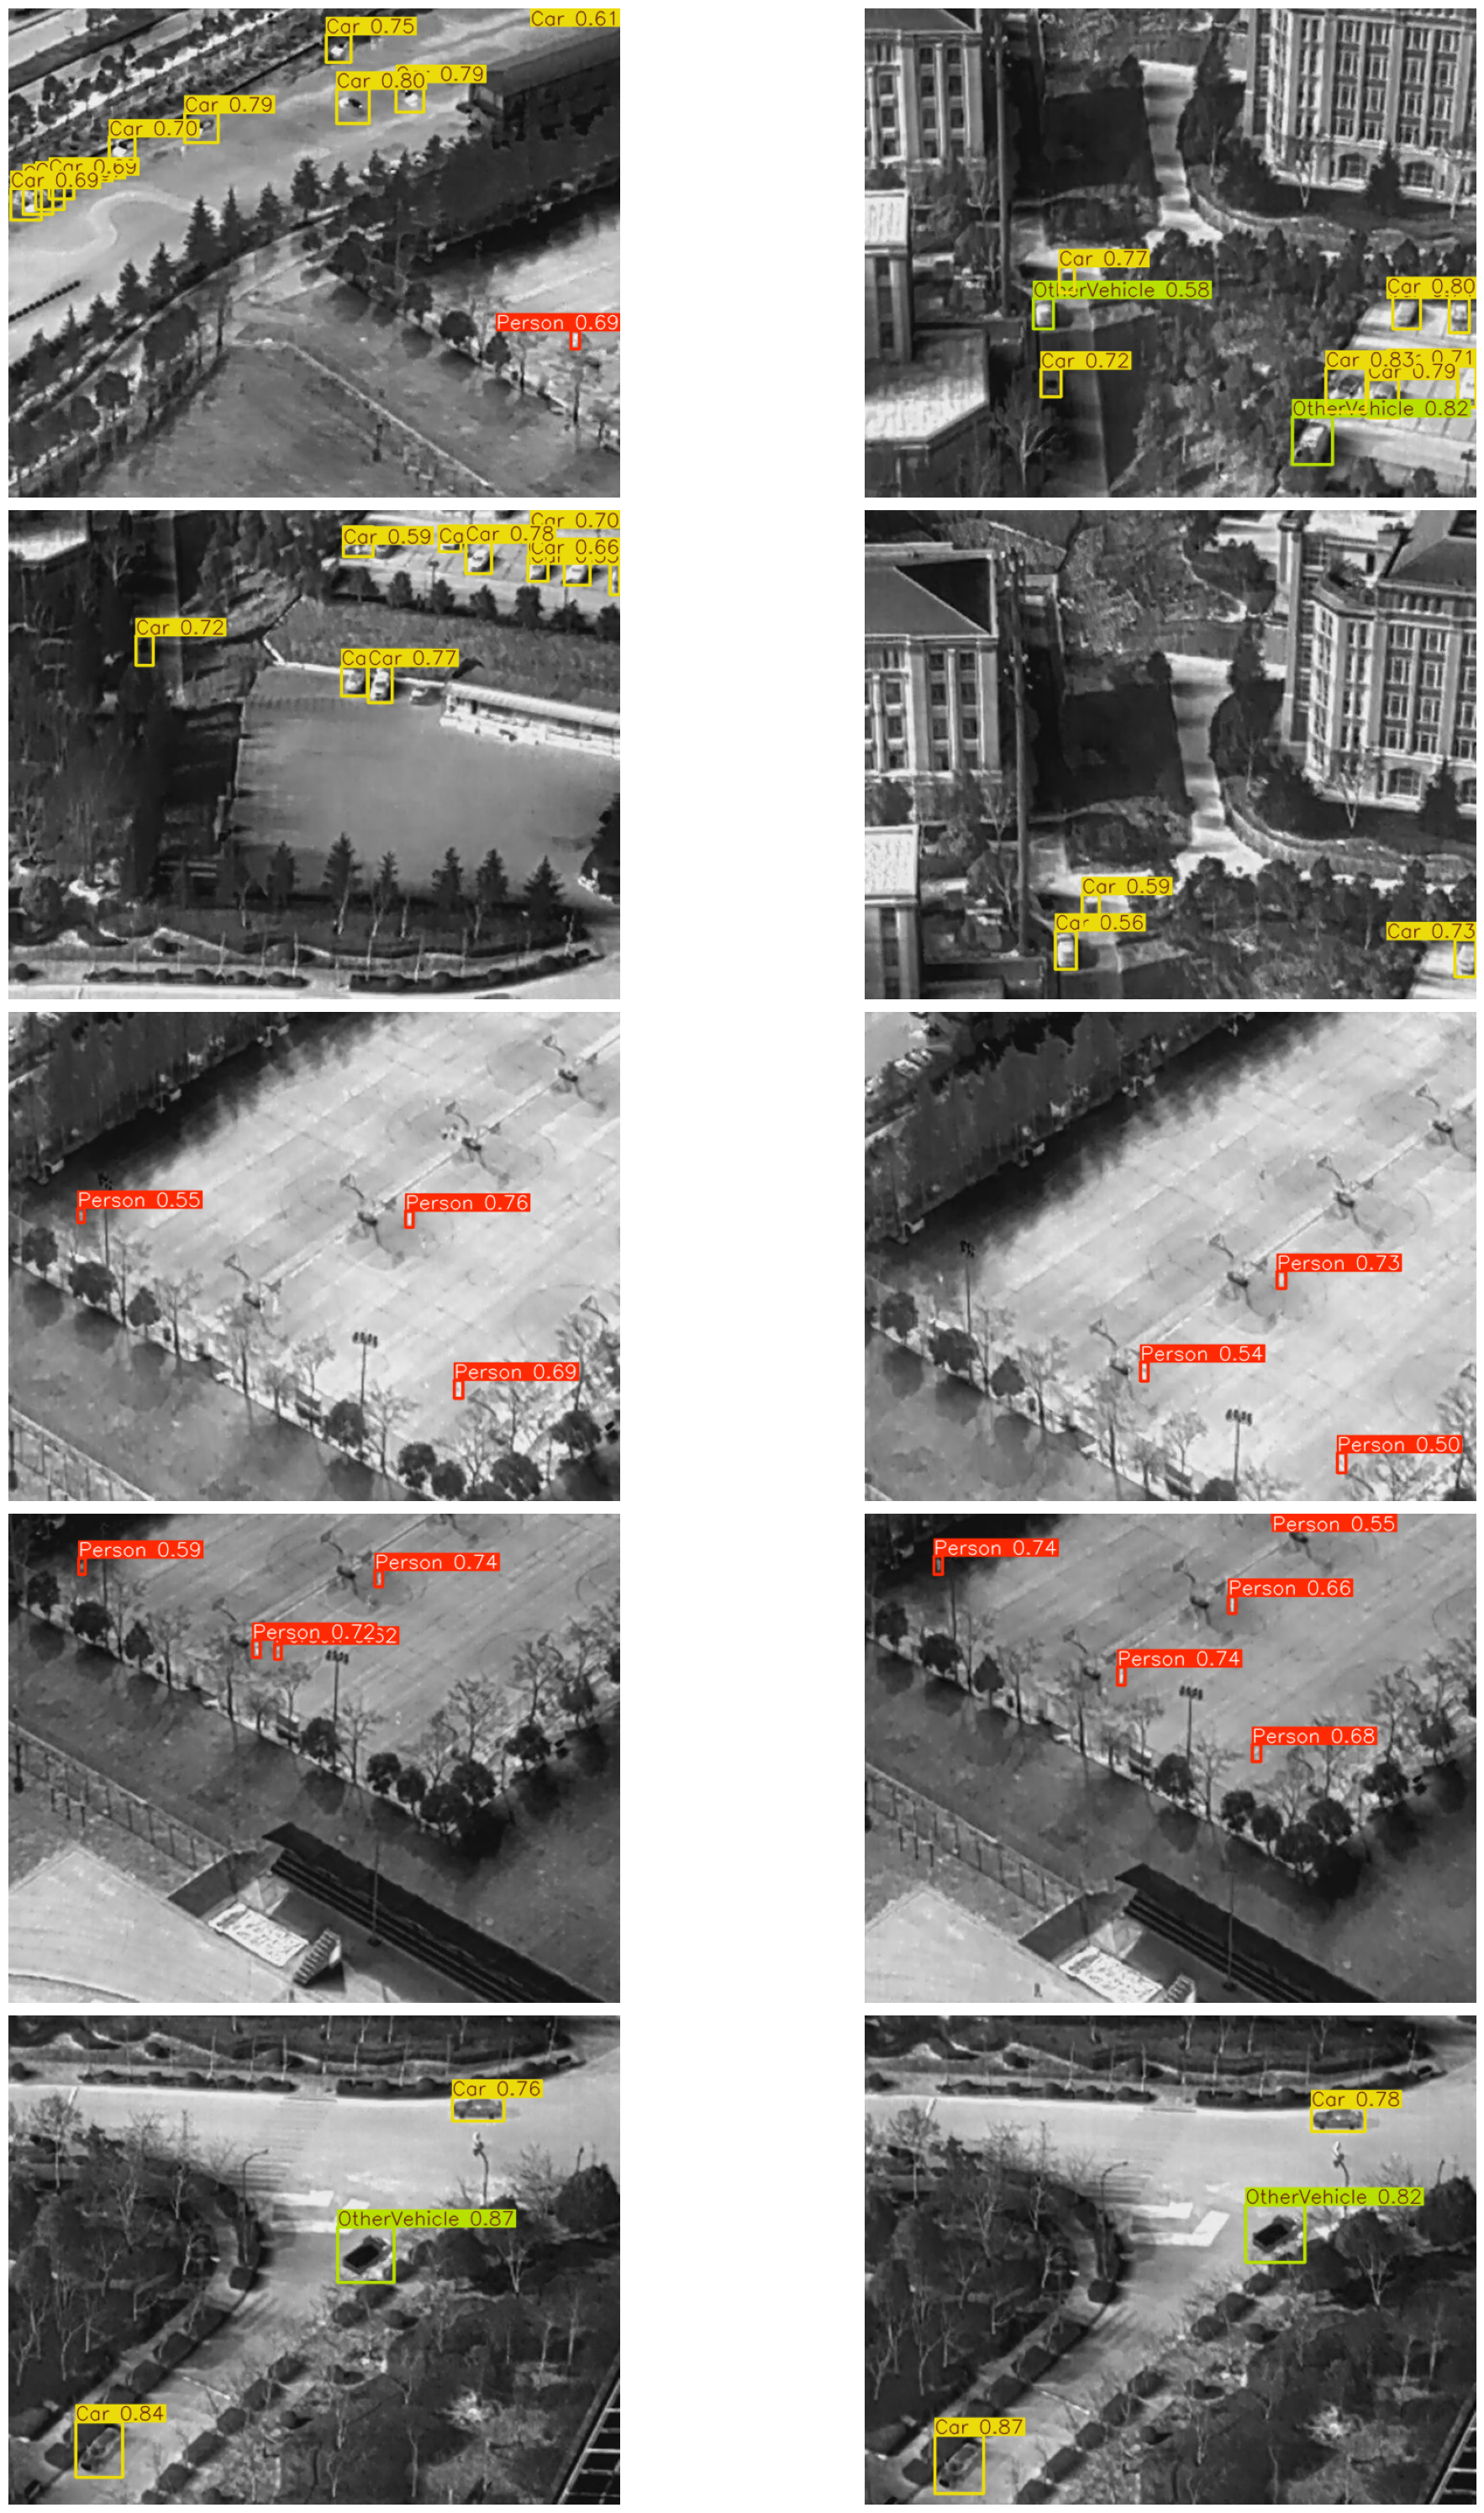

In [22]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compare predictions with ground truth

In [23]:
ground_colors = [(255, 0, 0) for _ in range(len(classes))]

In [24]:
!ls runs/detect

predict  train


In [25]:
success = best_efficientnet_model.export(format="onnx")  # export the model to ONNX format
success

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
model summary: 300 layers, 47,514,331 parameters, 0 gradients, 103.3 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (91.1 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.11.13 environment at: /usr
Resolved 25 packages in 270ms
 Downloaded onnxruntime-gpu
 Downloaded sympy
Prepared 6 packages in 2.97s
Uninstalled 2 packages in 183ms
Installed 6 packages in 59ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.74
 - protobuf==3.20.3
 + protobuf==6.33.1
 - sympy==1.13.1
 + sympy==1.14.0

requirements: AutoUpdate success ✅ 3.9s
WARNING

'/kaggle/working/runs/detect/train/weights/best.onnx'